# Time Series: Linear and Non-linear

## README

To run this project, the following packages need to be first installed, inlcuding pandas_datareader, datetime and pykalman. The required dataset can be found on finance.yahoo.com. All the data is been downloaded automatically through pacakge pandas_datareader.

In [1]:
! pip install pandas_datareader
! pip install datetime
! pip install pykalman

## Introduction

 Time series modeling is an important technique in a lot of areas, such as finance, meteorology, biology and so forth. The primary goal of time series is forecasting and signal detecting. In general, time series is a series of discrete time data points indexed in a time order.
 
 A time series $ \{ y_1,y_2,y_3,...,y_T \} $ is  a set of repeated oberservations of the same random variable $Y_t$ over time. We will denote y_t as the realization of the random variable and Y_t as the random variable itself. Observed sample $ \{ y_t \} _ {t=1} ^ {T} $ can be viewed as a finite segment of an infinite sequence $ \{ y_t \} _{t=-Inf} ^{+Inf}$.
 
 Simple examples of time series inculde:
 
   $\space$$\space$  Time trend: $Y_t=t$
 
   $\space$$\space$  Constant: $Y_t=c$
 
   $\space$$\space$  White noise: $Y_t=\epsilon_t$ , $\epsilon_t \sim  iid  N(0,\sigma^2)$
 
 Here is an example of time series data. A very common real world time series data is stock returns. Here is the plot of SP500 returns of year 2019.

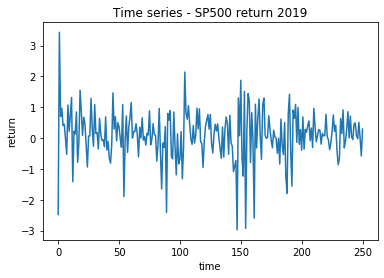

In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt

sp500 = DataReader('^GSPC','yahoo',datetime(2019,1,1),datetime(2019,12,31))
price = sp500['Adj Close']
sp500['ret'] = price/price.shift(1)-1
ret = sp500['ret'].values[1:]*100

plt.plot(ret)
plt.xlabel('time')
plt.ylabel('return')
plt.title('Time series - SP500 return 2019')
plt.show()

## Hypothesis

Compare between linear and non-linear time series models. Nonlinear time series models, such as Kalman filter can do a better work that linear models when true varialbes cannot be measured directly, or when there is a hidden state that is time dependent.

### Lag operators

Lag operator is denoted by the symbol L and allows us to express the lags or the leads of a time series. Here are how we usually us lag operator:

L(c) = c, c is constant

$L(y_t) =  y_{t-1}$

$L(L(y_t)) = L(y_{t-1}) = y_{t-2}$

$L^k(y_t) = y_{t-k}$, note that k can be positive or negative; so,

$L^{-k}(y_t) = y_{t+k}$

$L(\phi y_t) = \phi y_{t-1}$

$L(x_t+y_t) = x_{t-1}+y_{t-1}$



### Stationary

A very important assumption of time series models is stationary. A stationary time series means that many statistical properties of a time series do not change over time.


Strict stationary means that the joint distribution does not change over time. More specifically, it means that the joint distribution of $\{y_t,y_{t+1},y_{t+2},...,y_{t+s}\}$ depends only on s but not on t.

Strict stationary is a very strong assumption. While what we usually need is weak stationary, or we say, covariance stationary. Covaraiance stationary means that mean and autocovariance do not change over time, that is:

$\space$ $\space$ $E(Y_t) = \mu$ for all t

$\space$ $\space$ $E(Y_t-\mu)(Y_{t-j}-\mu) = \gamma_j$ for all t and any j

$\space$ $\space$ Also note that $\gamma_j=\gamma_{-j}$.

Strict stationary implies covariance stationary because when joint distribution is not changing, mean and covariances must keep the same. However, covariance stationary does not imply strict stationary.

Since stationary is a very important assumption in time series models, non-stationary data are often transformed to become stationary. For example, when there is a trend in mean, it would be helpful if we remove that trend.

### Unit Root Test: Augmented Dickey-Fuller test

To test for stationarity of a series, we can use unit root test. Existence of unit root means that the series is not stationary. A commonly used unit root test is called Augmented Dickey-Fuller test (ADF test). Here is the hypothesis of ADF test:

$\space$ $\space$ Null Hypothesis (H0) : the unit root exists and the series is not stationary

$\space$ $\space$ Alternative Hypothesis (H1) : the unit root does not exist and the series is stationary
    
Here is the example of how to implement ADF test in python and how to interpret it.

In [4]:
from statsmodels.tsa.stattools import adfuller

#generate simulated data
fakedata1=np.zeros(100)
fakedata2=np.zeros(100)

for i in range(100):
    fakedata1[i]=10+np.random.normal(0,1,1) 
    fakedata2[i]=i+np.random.normal(0,1,1)

#do ADF test on simulated data
res1=adfuller(fakedata1)
res2=adfuller(fakedata2)

#combine test result
ressum= {'Data':['fakedata1','fakedata2'],
        'ADF statistic':[res1[0],res2[0]] ,
        'p value': [res1[1],res2[1]]}

ressum=pd.DataFrame(ressum)

print(ressum)

        Data  ADF statistic       p value
0  fakedata1     -11.690179  1.659972e-21
1  fakedata2      -0.553691  8.811064e-01


Above is the example of ADF test using fake data. The fake data is generated as:

$\space$ $\space$ fakedata1: $y_t = 10 + \epsilon_t$, $\epsilon_t \sim  iid  N(0,1)$

$\space$ $\space$ fakedata2: $y_t = t + \epsilon_t$, $\epsilon_t \sim  iid  N(0,1)$

It could be easily see that fakedata1 is stationary while fakedata2 is not since $E(y_t) = 10 $ for fakedata1 abd $E(y_t) = t $ for fakedata2. The result of ADF test suggests the same thing. For fakedata1, p value is 0, which means we reject null hypothesis and conculde that the series is stationary. For fakedata2, p value is greater than 0.1, which means we cannot reject null hypthesis that unit root exists and it is not stationary.

If we want to apply time series models on fakedata2, one easy way is that we romove the trend of that data. That is, instead of fitting models on $y_t$, we fit models on $z_t = y_t-t = \epsilon_t$. Then the series $Z_t$ becomes stationary.

## AR and MA

### Moving Average (MA)

The moving average model (MA) has the ouput depends linearly on current and previous values. MA(q) model means a moving average model with order q. The notation of MA(q) model is:

$\space$$\space$ $Y_t=\mu+\sum_{j=1}^q\theta_j\epsilon_{t-j}+\epsilon_t$, where $\epsilon_t$ is white noise, $\epsilon_t \sim  iid  N(0,\sigma^2)$

From there we can get that: 
$$E(Y_t) = \mu + E(\sum_{j=1}^q\theta_j\epsilon_{t-j}+\epsilon_t) = \mu$$

$$Var(Y_t) = E(Y_t-\mu)(Y_t-\mu)$$
$$= E(\sum_{j=1}^q\theta_j\epsilon_{t-j}+\epsilon_t)(\sum_{j=1}^q\theta_j\epsilon_{t-j}+\epsilon_t)$$
$$= (1+\sum_{j=1}^q\theta_j^2)\sigma^2$$

$$Cov(Y_t,Y_{t-s}) = E(Y_t-\mu)(Y_{t-s}-\mu)$$
$$= E(\sum_{j=1}^q\theta_j\epsilon_{t-j}+\epsilon_t)(\sum_{j=1}^q\theta_j\epsilon_{t-s-j}+\epsilon_{t-s})$$
$$= (\theta_s + \theta_{s+1}\theta_1+...+\theta_q\theta_{q-s})\sigma^2, \space s \leq q$$


$$Cov(Y_t,Y_{t-s}) = 0 , \space s>q$$

These also suggest that MA must be stationary since expected value and covariances are inpendent from t.

### Autoregressive Model (AR)

Autoregressive model (AR) is a time series model that uses observations from previous time steps as input. AR model is not always stationary.

The notation of AR(p) indicate an AR model of order p. The model is defined as:

$\space$$\space$ $y_t=c+\sum_{j=1}^p\phi_jy_{t-j}+\epsilon_t$, where c is constant and $\epsilon_t$ is white noise.


$\thinspace$

$\thinspace$

$\thinspace$


Start with the most simple case: AR(1). When $|\phi|<1$, or we say the root of $(1-\phi L)$ lies outside the unit circle, the AR process is stationary. And an interesting thing is that AR(1) can be written as MA($\infty$).

$$Y_t = \phi Y_{t-1} + c + \epsilon_t$$
$$Y_t = \phi LY_t + c + \epsilon_t$$
$$(1-\phi L)Y_t = c + \epsilon_t$$
$$Y_t = \frac{c}{1-\phi L} + \frac{\epsilon_t}{1-\phi L}$$

Then we look back to our condition on $\phi$, we need $|\phi|<1$, or we say the root of $(1-\phi L)$ lies outside the unit circle, because only under that condition, we have that: 

$$\frac{1}{1-\phi L} = 1+\sum_{i=1}^{\infty}(\phi L)^i$$

This means that:
$$E(Y_t) = \frac{c}{1-\phi L} = c(1+\sum_{i=1}^{\infty}(\phi L)^i) = c(1+\sum_{i=1}^{\infty}\phi^i) = \frac{c}{1-\phi}$$

Let $\mu = E(Y_t)$

$$Var(Y_t) = E(Y_t-\mu)(Y_t-\mu)$$
$$= E(\frac{\epsilon_t}{1-\phi L})(\frac{\epsilon_t}{1-\phi L})$$
$$= (1+\sum_{i=1}^{\infty}(\phi L)^{2i}) \sigma^2$$
$$= \frac{\sigma^2}{1-\phi^2}$$

Similarly, 
$$Cov(Y_t,Y_{t-1}) = E(Y_t-\mu)(Y_{t-1}-\mu) = \phi \frac{\sigma^2}{1-\phi^2}$$
$$Cov(Y_t,Y_{t-j}) = 0, j>1$$


$\thinspace$

$\thinspace$

$\thinspace$

We can do the same thing for larger orders. For AR(p),

$$Y_t = c+\sum_{j=1}^p\phi_jY_{t-j}+\epsilon_t$$
$$Y_t = c+\sum_{j=1}^p\phi_j L^j Y_{t}+\epsilon_t$$
$$(1-\phi_1 L-\phi_2 L^2 -   - \phi_p L^p) Y_t = c + \epsilon_t$$
$$Y_t = \psi(L)c+\psi(L)\epsilon_t$$,

where $\psi(L) = (1-\phi_1 L-\phi_2 L^2 - \phi_p L^p)^{-1}$.

Similar to AR(1), all we need is that all the roots of $(1-\phi_1 L-\phi_2 L^2  - \phi_p L^p)$ lie outsid the unit circle so that the process is stationary. Then we can convert AR(p) to MA($\infty$) and get the covariances. $E(Y_t)$ is very straightforward:

$$E(Y_t) = \psi(L)c = \frac{c}{1-\phi_1-\phi_2-...-\phi_p}$$

## ARMA Process

We can combine AR(p) and MA(q) to become mixed autoregressive moving average process - ARMA(p,q). Again, let $\epsilon_t$ be a series of white noise. The following process is called autoregressive moving average process of order p and q (ARMA(p,q)):

$$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$$

$\thinspace$

Using lag operator, it can be expressed as:

$$(1-\phi_1 L - \phi_2 L^2 - ... -\phi_p L^p)Y_t=c+(1+\theta_1 L+\theta_2 L^2+...+\theta_q L^q)\epsilon_t$$
$$Y_t=\mu+\psi (L) \epsilon_t$$

where

$$\mu = \frac{c}{1-\phi_1  - \phi_2  - ... -\phi_p }$$
$$\psi (L) = \frac{1+\theta_1 L+\theta_2 L^2+...+\theta_q L^q}{1-\phi_1 L - \phi_2 L^2 - ... -\phi_p L^p}$$

$\thinspace$

As discussed above, MA process must be stationary. Thus, the stationarity of ARMA(p,q) process is determined by the AR part. As what AR(p) process have, ARMA(p,q) is covariance stationary when all the roots of $(1-\phi_1 L-\phi_2 L^2  - \phi_p L^p)$ lie outsid the unit circle.

When ARMA(p,q) is covariance stationary, we have

$$E(Y_t)=\mu= \frac{c}{1-\phi_1  - \phi_2  - ... -\phi_p }$$

### ACF and PACF

In real world, we need to determine the order of the model after we get the data. To determine the order of AR, MA and ARMA process, we need to calcuate autocorrelation and partial autocorrelation.

Autocorrelation is the correlation of the variable with its lags. The autocorrelation function (ACF) relates the lag length j and the autocorrelation of the variable with its j-th lag. The expression is:

$$\rho_j=\frac{Cov(Y_t,Y_{t-j})}{Var(Y_t)}$$

Partial autocorrelation is a conditional correlation. The partial autocorrelation function (PACF) relates the lag length j and the partial autocorrelation of the variable with its j-th lag. Different from autocorrelation which does not control for other lags, partial autocorrelation regressed the values of the time series at all shorter lags. The expresson is:

$$\alpha_j=\frac{Cov(Y_t,Y_{t-j}|Y_{t-1},...,Y_{t-j+1})}{\sigma(Y_t|Y_{t-1},...,Y_{t-j+1})\sigma(Y_{t-j}|Y_{t-1},...,Y_{t-j+1})}$$

$\thinspace$

In ARMA(p,q) process, ACF is used to determine order of MA,q, and PACF is used to determine order of AR, p. Here is the implementation in python.

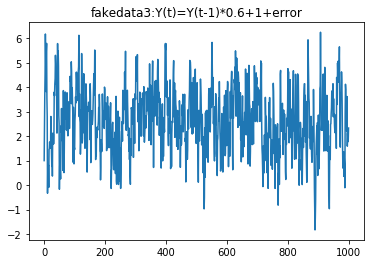

Mean of the series fakedata3 is: 2.65228741060098
Variance of the series fakedata3 is: 1.698161672832359


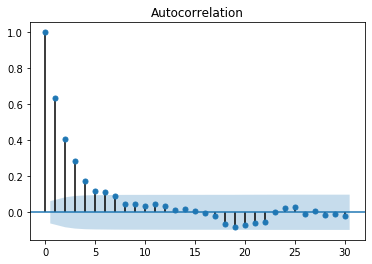

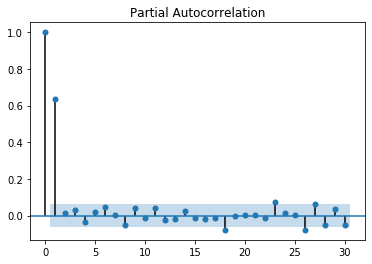

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#generate simulated data

fakedata3=np.ones(1000)
for i in range(999):
    fakedata3[i+1]=fakedata3[i]*0.6+1+np.random.normal(0,1,1)
plt.plot(fakedata3)
plt.title("fakedata3:Y(t)=Y(t-1)*0.6+1+error")
plt.show()

#check properties of ARMA process
print("Mean of the series fakedata3 is:",np.mean(fakedata3))
print("Variance of the series fakedata3 is:",np.var(fakedata3))

#plot acf and pacf
plot_acf(fakedata3)
plt.show()

plot_pacf(fakedata3)
plt.show()

Above is an example of using simulated data, called fakedata3. The fakedata3 is simulated by: $Y_t=0.6*Y_{t-1}+1+\epsilon_t$, $\epsilon_t \sim  iid  N(0,1)$. This is obviously an AR(1) process and remember AR(1) can also be written as MA($\infty$).

That is, $Y_t=\phi Y_{t-1}+c+\epsilon_t$, $\epsilon_t \sim  iid  N(0,\sigma^2)$. $\phi=0.6$, c=1 and $\sigma^2=1$.

First, check the mean and the variance of the series. Theoretically, the mean should be $\frac{c}{(1-\phi)}=1/(1-0.6)=2.5$ and the variance should be $\frac{\sigma^2}{(1-\phi^2)}=1/(1-0.6*0.6)=1.5625$. We can see the simulated data get very close results.

Then, move the the ACF and PACF plots. As discussed previously, PACF is used to determine the order of AR. We can see the PACF plot has a large value, around 0.6, at first lag and move close to 0 starting from second lag. From there, we get the the order of AR is 1. The value of first lag partial autocorrelation is just $\phi$, which is 0.6.

Looking at ACF plot. As discussed previously, AR(1) can be expressed as MA($\infty$). From the MA($\infty$) expression, we know that theoretally, $\rho_j=\phi^j$. The ACF plot above shows the same idea. The first lag autocorrelation is 0.6, the second lag autocorrelation is around 0.36. It has a exponential decay rate and dimishing to around 0 after few lags. This plot shows that the simulated data, fakedata3, can also be fitted using MA(5) or MA(6) model. As an AR(1) process, it should be equivalent to MA($\infty$), but larger orders have very small effect. As a resuly, according to ACF plot, MA(5) or MA(6) are also appropriate.

## Model Estimation

It is very convinient to fit the ARMA process in python. Simply use the ARIMA function and specify the orders. The function allow us to specify the order using (p,d,q), where p is order of AR, q is order of MA and d is number of difference. Again, using fakedata3, here is the implementation.

In [6]:
from statsmodels.tsa.arima_model import ARIMA
#fit three ARMA models on previous simulated data

print("AR(1)")
model1=ARIMA(fakedata3,order=(1,0,0))
result1=model1.fit(disp=0)
print(result1.summary())

print("MA(3)")
model2=ARIMA(fakedata3,order=(0,0,3))
result2=model2.fit(disp=0)
print(result2.summary())

print("ARMA(1,3)")
model3=ARIMA(fakedata3,order=(1,0,3))
result3=model3.fit(disp=0)
print(result3.summary())

AR(1)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1427.148
Method:                       css-mle   S.D. of innovations              1.008
Date:                Fri, 24 Apr 2020   AIC                           2860.297
Time:                        19:11:38   BIC                           2875.020
Sample:                             0   HQIC                          2865.893
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6489      0.087     30.494      0.000       2.479       2.819
ar.L1.y        0.6337      0.024     25.915      0.000       0.586       0.682
                                    Roots     

Above is the model fitting using AR(1), MA(3) and ARMA(1,3). Comparing AIC and BIC, ARMA(1,3) is definitely the worst. AR(1) is always the best when comparing BIC because BIC gives penalty to more variables included. If comparing AIC, AR(1) and MA(3) are close to each other.

It is convinient using the built in package, but it is important to know that the result can be replicated by OLS (linear regression) and MLE (maximum likelihood estimation).

### Ordinary Least Squares (OLS)

Again, using fakedata3, as we know it is an AR(1) process and we check it by PACF plot, we can simply regress $Y_t$ by $Y_{t-1}$. Just do what we do in linear regression, fit the model $Y_t=\beta_0+\beta_1Y_{t-1}$. And we should get $\beta_0=0, \beta_1=0.6$ as how we simulated the data. Below is the result. And we can see that we get the close result.

In [7]:
import statsmodels.api as sm
modelols=sm.OLS(fakedata3[1:],sm.add_constant(fakedata3[:-1]))
resultols=modelols.fit()
print(resultols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     669.3
Date:                Fri, 24 Apr 2020   Prob (F-statistic):          2.51e-113
Time:                        19:11:53   Log-Likelihood:                -1425.2
No. Observations:                 999   AIC:                             2854.
Df Residuals:                     997   BIC:                             2864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9741      0.072     13.463      0.0

### Maximan Likelihood Estimation (MLE)

Another more widely used approach in time series is maximum likelihood estimation (MLE). Again, using fakedata3 as an example, we can write the log-likelihood function for AR(1) process with Gaussian assumption. With some algebra, it can be proved that MLE is equivalent to OLS with Gaussian assumption.

Given that $\epsilon_t \sim iid N(0,\sigma^2)$, we have:

$$ f(y_t|y_{t-1},\beta)=\frac{1}{(2\pi)^{1/2}\sigma}exp\{\frac{-(y_t-\beta_0-\beta_1 y_{t-1})^2}{2\sigma^2}\} $$

This implies that the log-likelihood:
$$l(\beta)=-\frac{T-1}{2}ln(2\pi)-\frac{T-1}{2}ln(\sigma^2)-\sum_{t=2}^T\frac{(y_t-\beta_0-\beta_1*y_{t-1})^2}{2\sigma^2}$$

$\thinspace$

We can then maximize loglikelihood to get the coefficients. Below is the implementation in python. First, we write down the log-likelihood function. Then we maximize the function and get the coefficients. Remember that in the simulated data, we use c=1, $\phi=0.6$, $\sigma^2=1$. It means we should get $\beta_0=c=1$, $\beta_1=\phi=0.6$, and $\sigma^2=1$. We can see that the results from MLE is very close to the theoretical value.

In [8]:
from scipy.optimize import minimize

#calculate log likelihood for AR(1)
def ar1_like(param):
    T=Y.shape[0]-1
    b0=param[0]
    b1=param[1]
    sig2=np.exp(param[2])
    
    resids=Y[1:]-b0-b1*Y[:-1]
    loglikelist=np.zeros(T)
    
    for i in range(T):
        loglikelist[i]= (1/2)*np.log(2*np.pi)+(1/2)*np.log(sig2)+(1/2)*(resids[i]*resids[i]/sig2)
    likelihood=np.sum(loglikelist)
    return likelihood

Y=fakedata3

#estimate coefficients by MLE
param0=np.array([2, 0.3, 0.8])
param_final = minimize(ar1_like, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
print("-----------------------------------------------------------------")
print("b0 is ",param_final.x[0]," , it should be 1.")
print("b1 is ",param_final.x[1]," , it should be 0.6.")
print("sigma squared is ",np.exp(param_final.x[2])," , it should be 1.")

Optimization terminated successfully.
         Current function value: 1425.160294
         Iterations: 11
         Function evaluations: 65
         Gradient evaluations: 13
-----------------------------------------------------------------
b0 is  0.9740564817231286  , it should be 1.
b1 is  0.6332958091447621  , it should be 0.6.
sigma squared is  1.0154142909781134  , it should be 1.


/Users/shirleycai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: OptimizeWarning: Unknown solver options: xtol


## Nonlinear Models: Kalman Filter

In real world, situations may be very complex. One of the most important problem is that sometimes the series of data is measured containing noise and other inaccuracies.When true data can only be measured indirectly, or there would be a significant measurement error, nonlinear time series models can be introduced to deal with these problems.

Kalman filter is a very good algrithm to use when the true state cannot be observed directly. Kalman filter has a wide application in navigation, signal processing and econometrics. Kalman filter includes obeserved variables and unobserved states.

To be more specific, denote $y_t$ as variables observed at time t,
$x_t$ as unobserved variables, or we say state variables, the true state.

Assuming true state is AR(1), and we have:

$$y_t=Ax_t+w_t$$
$$x_t=Fx_{t-1}+v_t$$

$v_t, w_t$ are white noise processes.

$\thinspace$

The coeffient estimation includes producing and updating. Denote P as covaraiance matrix. The steps are:

$\space$$\space$$\space$ 1 Produce a forecast of $y_t$: it generates $\widehat{y_{t|t-1}}$ as well as $E[(y_t-\widehat{y_{t|t-1}})(y_t-\widehat{y_{t|t-1}})']$

$\space$$\space$$\space$ 2 Update: it generates $\widehat{x_{t|t}}$ as well as $P_{t|t}$

$\space$$\space$$\space$ 3 Forecast: it generates $\widehat{x_{t+1|t}}$ as well as $P_{t+1|t}$

## Compare

Now, we can see how Kalman filter can give better estimation when real state cannot be observed directly.

Use the SP500 stock return data we have, stock return is a reflction of the condition of financial market. It is obvious that when financial market is good, returns should be high; and while financial market is bad, returns are low. The problem of stock return data is that while the condition of finance market should have a cycle and thus exists autocorrelation, stock return is only an indirect measurement of the condition of financial market. Stock returns could be easily changed by some other factors such as people's inaccurate understanding about current market, or some fiscal policy. As a result, the true state, the financial market condition, is unobserved. When ture state cannot be observed, fitting linear model on stock return may not give a very good estimaton.

We assume true financial market condition follows an AR(1) process. This assumption is very widely accepted in many financial papers. As a result, we also fit AR(1) model on observed data, which is SP500 return.

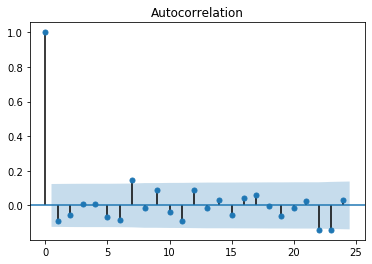

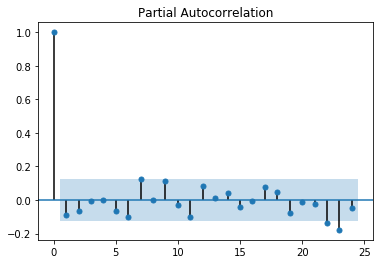

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#plot acf and pacf for SP500 returns
plot_acf(ret)
plt.show()

plot_pacf(ret)
plt.show()

We first plot ACF and PACF on stock returns. It seems that all the autocorrelations and partial autocorrelations are close to 0. Thus, non of the lags should be included in the model. We can check this result by fitting an AR(1) model on the data as well.

In [10]:
#fit AR(1) on SP500 return by MLE 
Y=ret

param0_linear=np.array([2, 0.3, 0.8])
param_final_linear = minimize(ar1_like, param0_linear, method='BFGS', options={'xtol': 1e-8, 'disp': True})
print("-----------------------------------------------------------------")
print("b0 is ",param_final_linear.x[0])
print("b1 is ",param_final_linear.x[1])
print("sigma squared is ",np.exp(param_final_linear.x[2]))

Optimization terminated successfully.
         Current function value: 288.320562
         Iterations: 15
         Function evaluations: 95
         Gradient evaluations: 19
-----------------------------------------------------------------
b0 is  0.12344890781578187
b1 is  -0.09148641446593495
sigma squared is  0.5878328631685371


/Users/shirleycai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: OptimizeWarning: Unknown solver options: xtol
  """


By fitting AR(1) on SP500 return data, we can see that $\beta_1$, or $\phi$ is close to 0. This means that the return is not correlated with its lags. This is not reasonable since financial market should be  a serial correlation. In fact, it tends to be positive since financial market should have persistency.

This problem could be solved using Kalman filter. Again, assuming that the state variable follows AR(1) and stock return is an indirect measurement of the state. Use pykalman package in python to filter the raw data and assume AR(1) for state variable. The result is below.

In [11]:
from pykalman import KalmanFilter

# do Kalman filter on SP500 return, assume true state follows AR(1)
model_kalman=KalmanFilter()
state=model_kalman.filter(ret)

# estimate coefficients by MLE
Y=np.asarray(state[0])
param0_kalman=np.array([0, -0.2, 0.8,1])
param_final_kalman = minimize(ar1_like, param0_kalman, method='BFGS', options={'xtol': 1e-8, 'disp': True})
print(param_final_kalman.x)

Optimization terminated successfully.
         Current function value: 167.044867
         Iterations: 13
         Function evaluations: 108
         Gradient evaluations: 18
[ 0.08037908  0.28458158 -1.50151815  1.        ]


/Users/shirleycai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: xtol
  # Remove the CWD from sys.path while we load stuff.


Now, we get $\beta_1$, or $\phi$ to be 0.285. This value is more reasonable than an estimated coefficient close to 0 because financial market should exist a persistency.

## Conclusion

This project explains the properties of linear time series models, the assumptions and the estimation. The project introduce the properties of time series data theoretically and pratically. The project also check these properties using simulated data. Then the project extend to non-linear time series model, kalman filter, to deal with the problem that true states sometimes cannot be measured directly in real world. It compares the result of fitting model on stock returns, which is an indirect measurement of financial condition. It shows that when true state can only be measured indirectly, nonlinear model such as kalman filter can give a better estimation on coefficients.

## Quiz

1. Rewrite AR(1): $y_t=c+\phi y_{t-1} + \epsilon_t$ into MA($\infty$)?
2. What is covariance stationary? What is strict stationary? What is the relation between them?
3. How to test for covariance stationary?
4. For ARMA(p,q) model, how to specify the order of p and q after having the data?
5. How to determine whether an AR(p) process: $y_t=c+\phi_1 y_{t-1}+\phi_2 y_{t-2}+...+\phi_p y_{t-p} + \epsilon_t$ is stationary?
6. Show why under normal assumption, MLE is equivalent to OLS in linear regression?
7. Why do we need Kalman filter? What is its advantage?
8. Write down the expression of Kalman filter process? Specify which variable is observed variable and which one is hidden state.
9. Give some examples of the applications of Kalman filters. Explain why Kalman filter is more desiralbe than ARMA process in that field?

# Reference

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

https://www.asc.ohio-state.edu/de-jong.8/note1.pdf

https://stanford.edu/class/ee363/lectures/kf.pdf

https://ocw.mit.edu/courses/economics/14-384-time-series-analysis-fall-2013/lecture-notes/MIT14_384F13_lec1.pdf

https://pykalman.github.io

# LICENSE

Copyright <2020>  < XINYUE CAI >

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.